In [68]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from keras import Input, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, Concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')


In [69]:

# ----------------------------------------------------------------------------
# 0) Load and preprocess raw data
# ----------------------------------------------------------------------------
df = pd.read_csv('option data variable.csv', parse_dates=['date','exdate'])
df.rename(columns={'exdate':'maturity'}, inplace=True)
df.dropna(inplace=True)
df['strike_price'] /= 1_000

# core features
df['mid_price']   = (df['best_bid'] + df['best_offer']) / 2
df['days_to_exp'] = (df['maturity'] - df['date']).dt.days
df['is_call']     = (df['cp_flag']=='C').astype(int)
df['log_mny']     = np.log(df['underlying_price']/df['strike_price'])
df['log_mny2']    = df['log_mny']**2

# helper for SSR calculation
df['F'] = df['underlying_price'] * np.exp(df['risk_free_rate'] * df['days_to_exp'] / 252)
df['k'] = np.log(df['strike_price'] / df['F'])


In [70]:

# ----------------------------------------------------------------------------
# 1) Compute SSR labels per (date, maturity)
# ----------------------------------------------------------------------------
# 1a) ATM IV extraction
def get_atm(group):
    idx = (group['strike_price'] - group['F']).abs().idxmin()
    return pd.Series({
        'date': group.at[idx,'date'],
        'maturity': group.at[idx,'maturity'],
        'underlying_price': group.at[idx,'underlying_price'],
        'atm_iv': group.at[idx,'impl_volatility']
    })
atm = df.groupby(['date','maturity']).apply(get_atm).reset_index(drop=True)

# 1b) Numerator: Δ(ATM_IV)/Δ(ln S)
atm = atm.sort_values(['maturity','date'])
atm['dlnS'] = np.log(atm['underlying_price']).groupby(atm['maturity']).diff()
atm['dIV']  = atm['atm_iv'].groupby(atm['maturity']).diff()
atm['num']  = atm['dIV']/atm['dlnS']

# 1c) Denominator: slope of IV vs k around k≈0
def skew_slope(group):
    sub = group[np.abs(group['k'])<0.05]
    if len(sub)<5: return np.nan
    return np.polyfit(sub['k'],sub['impl_volatility'],1)[0]
skew = df.groupby(['date','maturity']).apply(skew_slope).reset_index(name='skew')

# 1d) Merge SSR and clean infinities
sr = pd.merge(atm,skew,on=['date','maturity'],how='inner')
sr['SSR'] = sr['num']/sr['skew']
# remove infinite or NaN SSR values
sr.replace([np.inf,-np.inf],np.nan,inplace=True)
sr.dropna(subset=['SSR'],inplace=True)
# attach SSR label back
df = pd.merge(df,sr[['date','maturity','SSR']],on=['date','maturity'],how='left')


In [71]:

# ----------------------------------------------------------------------------
# 2) Final feature and target setup
# ----------------------------------------------------------------------------
X_COLS = ['underlying_price','strike_price','impl_volatility',
          'risk_free_rate','days_to_exp','is_call','log_mny','log_mny2']
Y_COLS = ['mid_price','delta','gamma','vega','theta','SSR']

df.dropna(subset=X_COLS+Y_COLS,inplace=True)
df.sort_values('date',inplace=True)
df.reset_index(drop=True,inplace=True)

df_call,df_put = df[df['is_call']==1], df[df['is_call']==0]
# chronological train/val/test split
split=lambda g: (g.iloc[:int(.98*len(g))],
                 g.iloc[int(.98*len(g)):int(.985*len(g))],
                 g.iloc[int(.985*len(g)):])
call_tr,call_va,call_te=split(df_call)
put_tr,put_va,put_te =split(df_put)


In [72]:

# ----------------------------------------------------------------------------
# 3) Scaling
# ----------------------------------------------------------------------------
x_scal=StandardScaler().fit(pd.concat([call_tr,put_tr])[X_COLS])
ysc_c =StandardScaler().fit(call_tr[Y_COLS])
ysc_p =StandardScaler().fit(put_tr[Y_COLS])

prep=lambda df_,xs,ys:(xs.transform(df_[X_COLS]),ys.transform(df_[Y_COLS]))

cXtr,cYtr=prep(call_tr,x_scal,ysc_c)
cXva,cYva=prep(call_va,x_scal,ysc_c)
cXte,cYte=prep(call_te,x_scal,ysc_c)
pXtr,pYtr=prep(put_tr ,x_scal,ysc_p)
pXva,pYva=prep(put_va ,x_scal,ysc_p)
pXte,pYte=prep(put_te ,x_scal,ysc_p)


In [73]:

# ----------------------------------------------------------------------------
# 4) MLP builder with SSR head
# ----------------------------------------------------------------------------
def build_mlp(indim,hidden=512,layers=6,dropout=0.3,theta_w=2.0,ssr_w=1.0):
    x=Input(shape=(indim,))
    h=Dense(hidden)(x);h=LeakyReLU()(h)
    for _ in range(layers-1):
        h=Dense(hidden)(h);h=BatchNormalization()(h)
        h=LeakyReLU()(h);h=Dropout(dropout)(h)
    out=Dense(len(Y_COLS))(h)
    w=tf.constant([1.,1.,1.,1.,theta_w,ssr_w],dtype='float32')
    loss=lambda yt,yp:tf.reduce_mean(w*tf.square(yt-yp),axis=-1)
    m=Model(x,out);m.compile('adam',loss=loss)
    return m

CB=[EarlyStopping(patience=15,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5,patience=7)]


In [74]:

# ----------------------------------------------------------------------------
# 5) Train
# ----------------------------------------------------------------------------
call_m=build_mlp(cXtr.shape[1])
call_m.fit(cXtr,cYtr,validation_data=(cXva,cYva),
           epochs=60,batch_size=4096,callbacks=CB,verbose=1)

put_m=build_mlp(pXtr.shape[1])
put_m.fit(pXtr,pYtr,validation_data=(pXva,pYva),
          epochs=60,batch_size=4096,callbacks=CB,verbose=1)


Epoch 1/60
2106/2106 [==============================] - 34s 14ms/step - loss: 0.3433 - val_loss: 0.1201 - lr: 0.0010
Epoch 2/60
2106/2106 [==============================] - 29s 14ms/step - loss: 0.2567 - val_loss: 0.0972 - lr: 0.0010
Epoch 3/60
2106/2106 [==============================] - 29s 14ms/step - loss: 0.2449 - val_loss: 0.0925 - lr: 0.0010
Epoch 4/60
2106/2106 [==============================] - 29s 14ms/step - loss: 0.2397 - val_loss: 0.0796 - lr: 0.0010
Epoch 5/60
2106/2106 [==============================] - 31s 15ms/step - loss: 0.2351 - val_loss: 0.1137 - lr: 0.0010
Epoch 6/60
2106/2106 [==============================] - 30s 14ms/step - loss: 0.2324 - val_loss: 0.0780 - lr: 0.0010
Epoch 7/60
2106/2106 [==============================] - 30s 14ms/step - loss: 0.2294 - val_loss: 0.0884 - lr: 0.0010
Epoch 8/60
2106/2106 [==============================] - 30s 14ms/step - loss: 0.2282 - val_loss: 0.0688 - lr: 0.0010
Epoch 9/60
2106/2106 [==============================] - 31s 15ms

4125/4125 [==============================] - 16s 4ms/step

CALL MODEL
mid_price   MSE=3.330118  MAE=1.159735  R²=0.9989
delta       MSE=0.000867  MAE=0.019100  R²=0.9940
gamma       MSE=0.000588  MAE=0.003929  R²=0.9158
vega        MSE=6.891151  MAE=1.520624  R²=0.9965
theta       MSE=49.388810  MAE=2.339971  R²=0.9671
SSR         MSE=460212.710512  MAE=150.773710  R²=-0.0946
3919/3919 [==============================] - 15s 4ms/step

PUT MODEL
mid_price   MSE=1.240077  MAE=0.620026  R²=0.9986
delta       MSE=0.000743  MAE=0.016225  R²=0.9942
gamma       MSE=0.000562  MAE=0.005170  R²=0.9338
vega        MSE=10.786616  MAE=1.722027  R²=0.9933
theta       MSE=31.823118  MAE=2.177446  R²=0.9507
SSR         MSE=438085.941740  MAE=105.379614  R²=-0.0228


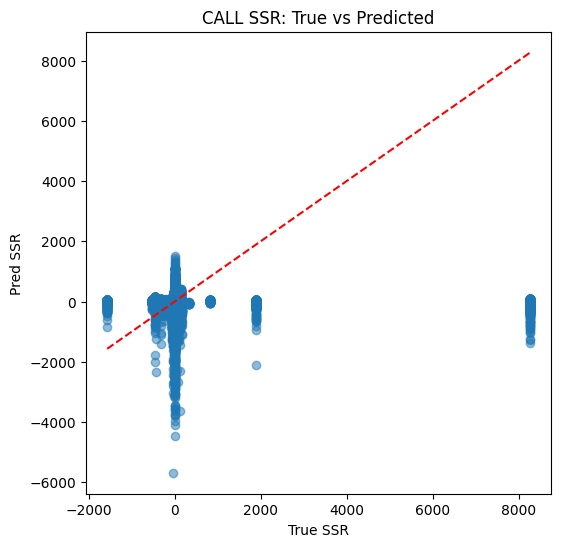

In [75]:

# ----------------------------------------------------------------------------
# 6) Evaluate
# ----------------------------------------------------------------------------
def evaluate(m,X,Y,ysc,tag):
    pred=ysc.inverse_transform(m.predict(X,verbose=1))
    true=ysc.inverse_transform(Y)
    print(f"\n{tag} MODEL")
    for i,n in enumerate(Y_COLS):
        mse=mean_squared_error(true[:,i],pred[:,i])
        mae=mean_absolute_error(true[:,i],pred[:,i])
        r2=r2_score(true[:,i],pred[:,i])
        print(f"{n:10s}  MSE={mse:.6f}  MAE={mae:.6f}  R²={r2:.4f}")
    return true,pred

c_t,c_p=evaluate(call_m,cXte,cYte,ysc_c,'CALL')
p_t,p_p=evaluate(put_m ,pXte,pYte,ysc_p,'PUT')

# scatter SSR
plt.figure(figsize=(6,6))
plt.scatter(c_t[:,-1],c_p[:,-1],alpha=0.5)
plt.plot([c_t[:,-1].min(),c_t[:,-1].max()],[c_t[:,-1].min(),c_t[:,-1].max()],'r--')
plt.title('CALL SSR: True vs Predicted')
plt.xlabel('True SSR');plt.ylabel('Pred SSR')
plt.show()